<a href="https://colab.research.google.com/github/JaeminKIM-Irene/FC_AI_Track_Learning/blob/main/CV/tutorial/%5BCV_realtime%5D7.%20Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 의료 영상 이미지를 이용해 Image segmentation을 진행해보자.
---
### 학습목표
* 위내시경 이미지에 용종을 표시한 데이터를 이용해 모델을 구성하고, 용종을 찾는  Segmentation 모델을 만들어보자.
* 적은 데이터셋을 활용하기 위한 Data augmentation을 진행해보자.
* Encoder-Decoder Model과 U-net 모델을 구현해보자.

## Project 설명
---
### Dataset
* 데이터셋은 [Gastrointestinal Image ANAlys Challenges (GIANA)](https://giana.grand-challenge.org) Dataset (About 650MB) 을 사용했다.
* Data와 labels는 이미지 데이터로 이루어져있으며, 이미지의 상세 스펙은 아래와 같다.
  * Train data: 300 images with RGB channels (bmp format)
  * Train labels: 300 images with 1 channels (bmp format)
  * Image size: 574 x 500
* Training시 **image size는 256**으로 resize해서 사용할 예정이다.

### Baseline code
* Dataset: train, test로 split 해서 이용한다.
* Input data shape: (`batch_size`, 256, 256, 3) RGB color images
* Output data shape: (`batch_size`, 256, 256, 1) Black and white images
* Architecture:
  * 간단한 Encoder-Decoder 구조 구현
  * U-Net 구조 구현
* Training


### Evaluation - MeanIOU
* Image Segmentation에서 많이 쓰이는 평가 기준이다.

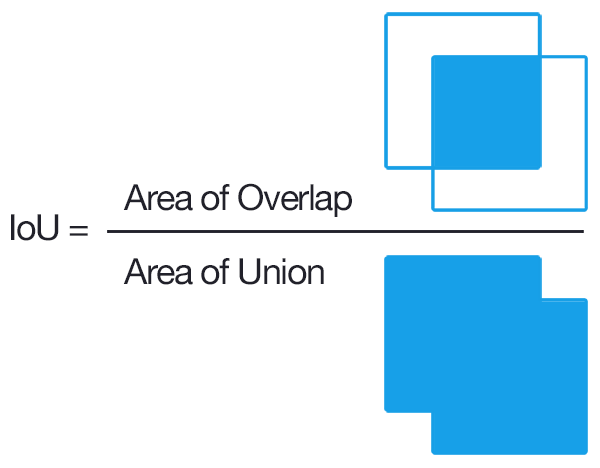


In [ ]:
use_colab = True
assert use_colab in [True, False]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import base modules

In [ ]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 사용 모델 선택
* 학습 및 inference에서 사용할 모델 선택

In [ ]:
is_train = True

#model_name = 'ed_model'
model_name = 'u-net'
assert model_name in ['ed_model', 'u-net']

In [ ]:
# GPU 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 데이터 수집 및 Visualize

### Download data

이 프로젝트는 [Giana Dataset](https://giana.grand-challenge.org/Dates/)을 이용하여 진행한다.

* 아래 코드를 이용해 Path를 설정한다


In [ ]:
if use_colab:
    DATASET_PATH='/content/drive/MyDrive/Colab Notebooks/data/Image_Segmentation/'
else:
    DATASET_PATH='../../datasets/'

### Split dataset into train data and test data
* 다운로드한 데이터셋을 분류해보자.
* 이미지를 직접 로드하는 것이 아닌 데이터의 주소 (data path)를 이용해서 train data와 test data를 분리한다.

In [ ]:
dataset_dir = os.path.join(DATASET_PATH)

img_dir = os.path.join(dataset_dir, "train")
label_dir = os.path.join(dataset_dir, "train_labels")

In [ ]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [ ]:

x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [ ]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


In [ ]:
x_train_filenames[0]

'/content/drive/MyDrive/Colab Notebooks/data/Image_Segmentation/train/47.bmp'

### Visualize

데이터 셋에서 5장 (`display_num`)의 이미지를 살펴보자.

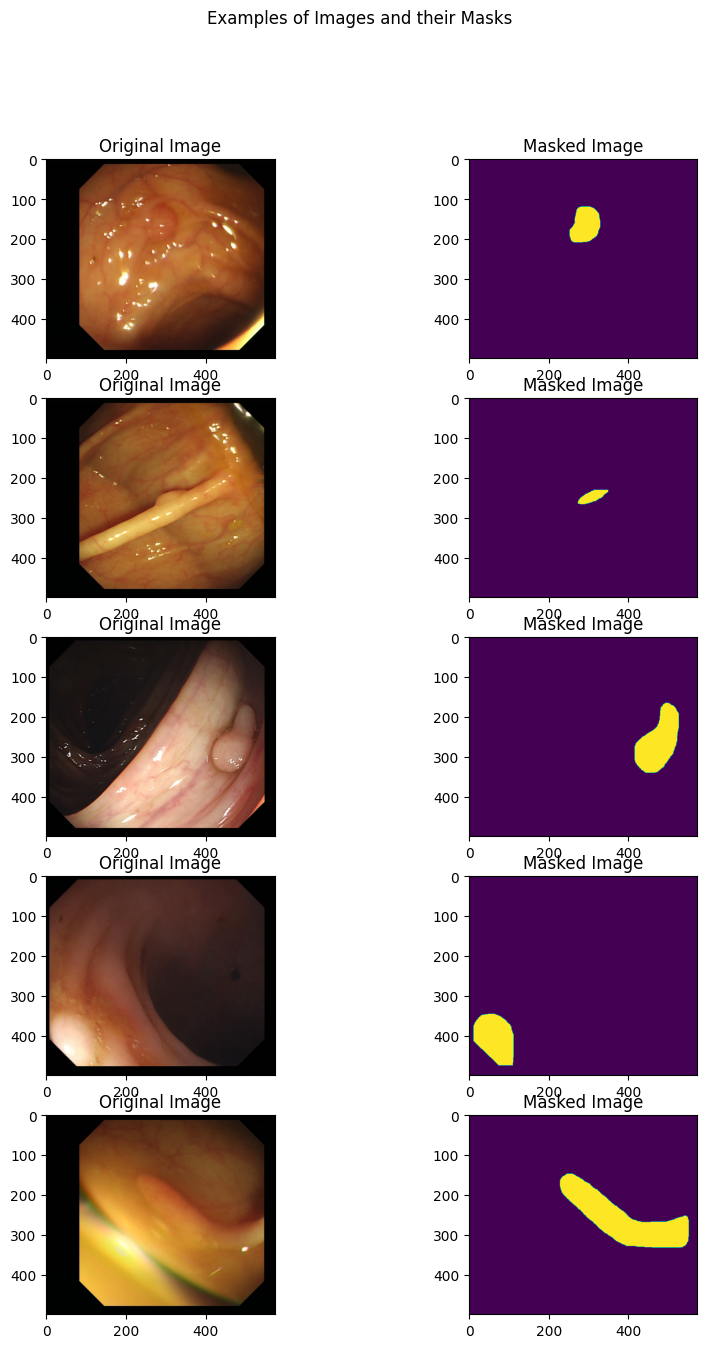

In [ ]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")

plt.suptitle("Examples of Images and their Masks")
plt.show()

## Data pipeline and preprocessing 만들기

### Set up hyper-parameters

* Hyper-parameter를 셋팅해보자. 이미지 사이즈, 배치 사이즈 등 training parameter들을 셋팅해보자.
* 직접 이미지 사이즈를 조절할 수 있다.

In [ ]:
# Set hyperparameters
image_size = 256

batch_size = 16
max_epochs = 100

if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/segmentation/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = './train_ckpt/segmentation/exp1'

#### Why do we do these image transformations?

Data augmentation은 딥러닝을 이용한 이미지 처리분야 (classification, detection, segmentation 등) 에서 널리 쓰이는 테크닉이다.

> 데이터 증가는 여러 무작위 변환을 통해 데이터를 증가시켜 훈련 데이터의 양을 "증가"시킵니다.
> 훈련 시간 동안 우리 모델은 똑같은 그림을 두 번 볼 수 없습니다.
> Overfitting을 방지하고 모델이 처음보는 데이터에 대해 더 잘 일반화되도록 도와줍니다.

In [ ]:
class SegDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label_path = self.label_paths[index]

        image = Image.open(image_path).convert('RGB')
        label = Image.open(label_path).convert('L')

        if self.transform:
            seed = torch.random.initial_seed()
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            label = self.transform(label)

        return image, label



In [ ]:
# 변환 정의
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 수평 뒤집기
    transforms.RandomVerticalFlip(p=0.5),    # 50% 확률로 수직 뒤집기
    transforms.RandomRotation(degrees=30),   # -30도에서 30도 사이로 무작위 회전
    transforms.ToTensor()
])

# 데이터셋 인스턴스 생성
train_dataset = SegDataset(x_train_filenames, y_train_filenames, transform=transform)
test_dataset = SegDataset(x_test_filenames, y_test_filenames, transform=transform)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# 데이터 로더 사용 예시
for images, labels in train_loader:
    print(images.size(), labels.size())
    break

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])


### Plot some train data
* train 데이터를 확인해보자
* data augmentation 이 적용된 이미지를 직접확인해보자.

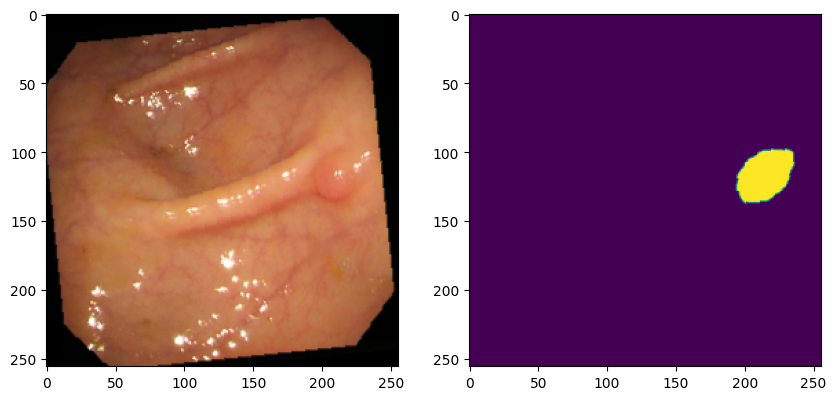

In [ ]:
for images, labels in train_loader:
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0].permute(1, 2, 0)
    lb = labels[0].permute(1, 2, 0)

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(lb)
    plt.show()
    break

## Build the model

해당 프로젝트는 두 개의 네트워크를 만들어보는 것이 목표이다.
* Encoder-Decoder 스타일의 네트워크

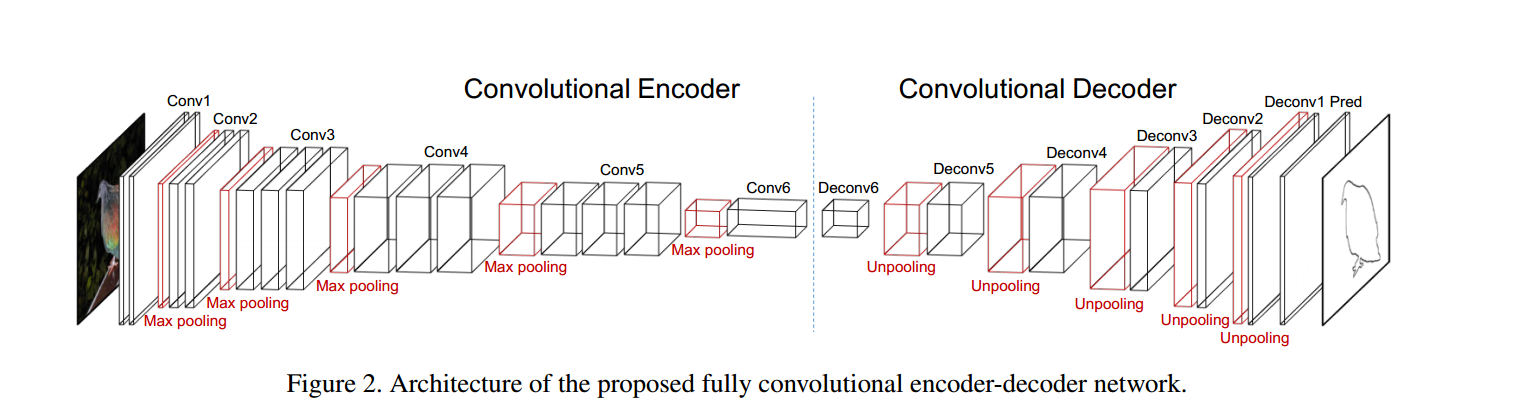


* Encoder를 이용해 우리가 가진 Train data를 작은 차원의 공간에 압축하는 방식으로 동작한다.
* Decoder는 Encoder가 압축한 데이터들을 우리가 원하는 label데이터와 같도록 재생성하는 방식으로 학습하게 된다.
    * 우리가 가진 label의 shape과 같은 형태로 데이터를 반환하게 된다.

### Encoder-Decoder architecture

#### Encoder
* 다음과 같은 구조로 Encoder로 만들어보자.
* `input data`의 shape이 다음과 같이 되도록 네트워크를 구성해보자
  * inputs = [batch_size, 256, 256, 3]
  * conv1 = [batch_size, 128, 128, 32]
  * conv2 = [batch_size, 64, 64, 64]
  * conv3 = [batch_size, 32, 32, 128]
  * outputs = [batch_size, 16, 16, 256]
* Convolution - Normalization - Activation 등의 조합을 다양하게 생각해보자.
* Pooling을 쓸지 Convolution with stride=2 로 할지 잘 생각해보자.
* `nn.Sequential()`을 이용하여 만들어보자.
  
#### Decoder
* Encoder의 mirror 형태로 만들어보자.
* `input data`의 shape이 다음과 같이 되도록 네트워크를 구성해보자
  * inputs = encoder의 outputs = [batch_size, 16, 16, 256]
  * conv_transpose1 = [batch_size, 32, 32, 128]
  * conv_transpose2 = [batch_size, 64, 64, 64]
  * conv_transpose3 = [batch_size, 128, 128, 32]
  * outputs = [batch_size, 256, 256, 1]
* `nn.Sequential()`을 이용하여 만들어보자.

In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder_block(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder_block = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.decoder_block(x)
        return x

class EnDnModel(nn.Module):
    def __init__(self):
        super(EnDnModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x


In [ ]:
# model = EnDnModel().to(device)
# from torchsummary import summary
# summary(model, (3, 256, 256))

In [ ]:
if model_name == 'ed_model':
    # 모델 인스턴스화
    endn_model = EnDnModel()

    # 모델 요약 출력 (옵션)
    print(endn_model)

### U-Net architecture

<img src='https://user-images.githubusercontent.com/11681225/58005153-fd934300-7b1f-11e9-9ad8-a0e9186e751c.png' width="800">

### U-Net
* [U-Net](https://arxiv.org/abs/1505.04597)

> Q. U-Net 구조의 특징은 무엇인가요?
> * FCN 구조를 가지며, skip-connection을 이용해 더 효율적인 학습을 구현할 수 있다.

In [ ]:
class Down(nn.Module):
    """인코더에서 사용되는 다운샘플링 블록"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        if in_channels == 3 :
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, 32, 3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        else :
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 3, stride=1, padding=1),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(),

                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        self.pool = nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=1)


    def forward(self, x):
        x = self.conv(x)
        pool = self.pool(x)
        return x, pool

class Up(nn.Module):
    """디코더에서 사용되는 업샘플링 블록"""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels, 3, stride=2, padding=1, output_padding=1)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels+out_channels, out_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),

            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = Down(3, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.final_conv = nn.Conv2d(64, 1, 3, stride=1, padding=1)

    def forward(self, x):
        x1, pool1 = self.down1(x)
        x2, pool2 = self.down2(pool1)
        x3, pool3 = self.down3(pool2)
        x4, pool4 = self.down4(pool3)

        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.final_conv(x)

        return x




In [ ]:
# model = UNet().to(device)
# from torchsummary import summary
# summary(model, (3, 256, 256))

#### Create a U-Net model
* 위에서 구현한 Class들을 생성해 최종적으로 U-net 모델을 구현해준다.


In [ ]:
# model_name = 'u-net'
# if model_name == 'u-net':
#     # 모델 인스턴스화
#     unet = UNet()

#     # 모델 요약 출력 (옵션)
#     print(unet)

### Defining custom metrics and loss functions

우리가 사용할 loss function은 다음과 같다.
* binary cross entropy
* dice_loss

* Image Segmentation Task에서 정답을 더 잘 찾아내기위해 새로운 Loss를 추가해 사용한다.
> [논문](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf)에 나온 Dice coefficient 수식

$$D = \frac{2 \sum_{i}^{N} p_{i}g_{i}}{\sum_{i}^{N} p_{i}^{2} + \sum_{i}^{N} g_{i}^{2}}$$

> Dice loss를 추가하는 이유는 segmentation task를 더 잘 수행하기위해서이다.

> Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습할 수 있다.

* Dice Loss가 최대화되는 방향으로 구해지기 때문에, 아래와 같이 사용한다.
* 새로운 Loss function을 사용하기위해서 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성한다.

In [ ]:
class BCE_DiceLoss(nn.Module):
    def __init__(self):
        super(BCE_DiceLoss, self).__init__()

    def forward(self, y_pred, y_true):
        # Binary Cross-Entropy 손실
        bce_loss = F.binary_cross_entropy_with_logits(y_pred, y_true)

        # Dice 손실
        smooth = 1e-10
        y_pred = torch.sigmoid(y_pred)
        y_true_f = torch.flatten(y_true)
        y_pred_f = torch.flatten(y_pred)
        intersection = torch.sum(y_true_f * y_pred_f)
        dice_loss = 1 - (2. * intersection + smooth) / (torch.sum(y_true_f ** 2) + torch.sum(y_pred_f ** 2) + smooth)

        # BCE와 Dice 손실의 결합
        loss = bce_loss + dice_loss

        return loss

## Train your model
* 모델 학습 이전에 모델에서 예측한 이미지를 출력할 수 있는 함수를 작성해 모델 성능 테스트에 사용하자.

### Training - `tf.GradientTape()` 함수 이용
* 학습을 진행하며, 위에서 구성한 Train dataset과 Test dataset등을 이용해 학습을 진행한다.
* 학습 데이터의 갯수가 부족하기때문에 Test dataset을 Validation dataset으로 사용한다.

### Select a model

In [ ]:
if model_name == 'ed_model':
    print('select the Encoder-Decoder model')
    model = EnDnModel()

if model_name == 'u-net':
    print('select the U-Net model')
    model = UNet()

model = model.to(device)

select the U-Net model


In [ ]:
# 손실 함수 및 옵티마이저
criterion = BCE_DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def plot_predictions(model, device, data_loader, num_images=1):
    model.eval()
    images, labels = next(iter(data_loader))

    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        outputs = torch.sigmoid(outputs)  # 모델의 출력을 시그모이드 함수로 변환

    images = images.cpu()
    labels = labels.cpu()
    outputs = outputs.cpu()

    plt.figure(figsize=(10, num_images * 3))
    for idx in range(num_images):
        plt.subplot(num_images, 3, idx * 3 + 1)
        plt.imshow(images[idx].permute(1, 2, 0))  # CHW -> HWC
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(num_images, 3, idx * 3 + 2)
        plt.imshow(labels[idx].squeeze(), cmap='gray')  # 레이블 이미지
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(num_images, 3, idx * 3 + 3)
        plt.imshow(outputs[idx].squeeze(), cmap='gray')  # 예측 결과
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

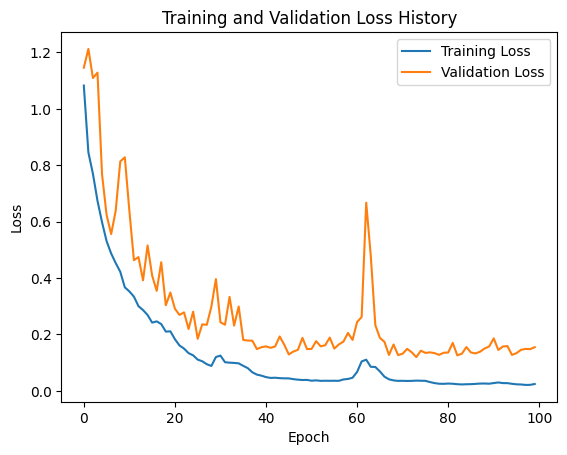

In [ ]:
# 손실 기록을 위한 리스트
train_loss_history = []
valid_loss_history = []

# 학습 및 검증 루프
for epoch in range(max_epochs):
    # 학습 부분
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)

    # 검증 부분
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            running_loss += loss.item()
    valid_loss = running_loss / len(test_loader)
    valid_loss_history.append(valid_loss)

    print(f"Epoch {epoch+1}/{max_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")
    plot_predictions(model, device, test_loader)

    time.sleep(1)
    clear_output(wait=True)

# 손실 기록 시각화
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate the test dataset
* 모델을 평가해보자.

* Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인해보자.

In [ ]:
def calculate_miou(preds, labels, n_classes):
    ious = []
    preds = torch.argmax(preds, dim=1)
    for cls in range(n_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            ious.append(float('nan'))  # 합집합이 0인 경우 NaN 처리
        else:
            ious.append(intersection / union)

    miou = sum(ious) / len(ious)
    return miou


In [ ]:
def test_model_with_miou(model, device, test_loader, n_classes, num_images=3):
    model.eval()
    total_miou = 0
    images_to_show = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            miou = calculate_miou(outputs, labels, n_classes)
            total_miou += miou

            if i < num_images:
                images_to_show.append((images.cpu(), labels.cpu(), outputs.cpu()))

    # 평균 mIoU 계산 및 출력
    avg_miou = total_miou / len(test_loader)
    print(f'Mean IoU on Test Dataset: {avg_miou:.4f}')

    # 예시 이미지 출력
    for i, (image, label, output) in enumerate(images_to_show):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image[0].permute(1, 2, 0))
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(label[0].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(output[0].squeeze(), cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

        plt.show()

Mean IoU on Test Dataset: 0.4729


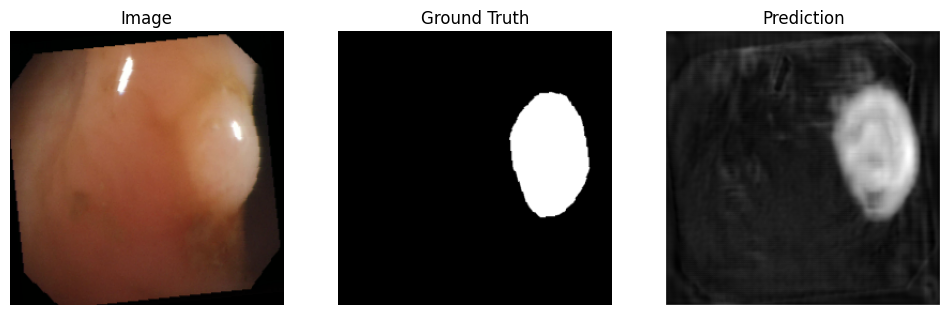

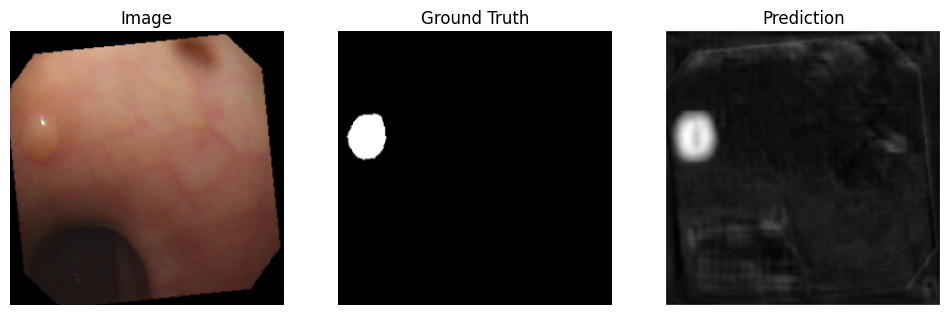

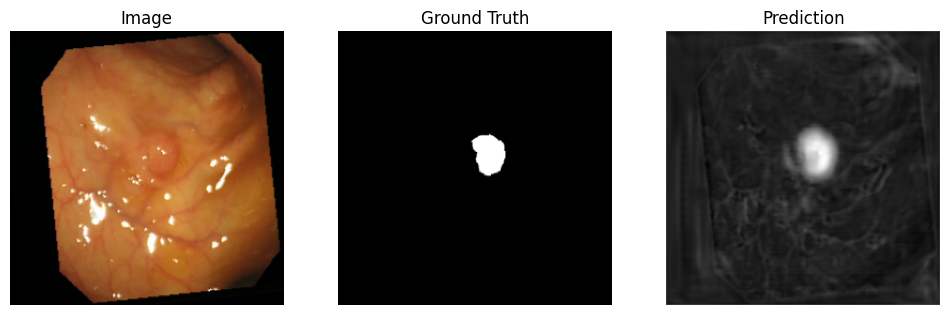

In [ ]:
test_model_with_miou(model, device, test_loader, n_classes=2, num_images=3)